# Multi-Linear Regression - Binary configuration

Alhough this dataset fits better to a classification problem, it is possible to use regression to solve it, by rounding the final output to a whole number, and using that result as the classification label.

Furthermore, if the desired output is only to know if the room is occupied or not, this problem can be transformed into a Binary Classification scenario.

In [1]:
# Import libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
from sklearn.model_selection import train_test_split

## Data Setup

In [2]:
# Read dataset and transform "Room_Occupancy_Count" into a binary colum
df = pd.read_csv('../Occupancy_Estimation.csv')

# Create training an testing datasets
df["Room_Occupancy_Count"] = [1 if value else 0 for value in df["Room_Occupancy_Count"]]
X_train, X_test = train_test_split(df, test_size=0.2)

## Multi-linear Regression without interactions
### Model Creation

In [3]:
# Make a list of all allowed features. Remove "Date", "Time" and "Room_Occupancy_Count"
possible = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 
            'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']

# Create initial variables for feature selection
base_formula = "Room_Occupancy_Count ~ "
fixed_features = []
adjusted_train_R_squared = []
models = []

# Set number of desired features for final model
number_of_features = 10

# For each iteration
for k in range(number_of_features):
    # Create an empty "best" variable
    best = ["", 0, "", None]
    
    # For each possible factor
    for factor in possible:
        # Calculate formula using factor
        formula = base_formula + ("" if k == 0 else "+ ") + factor
        
        #Create new model and fit it
        model = smf.ols(formula=formula, data=X_train).fit()
        
        # If model is best yet, store its data
        if(model.rsquared_adj > best[1]):
            best = [factor, model.rsquared_adj, formula, model]
    
    # Store best model's data in global variables
    fixed_features.append(best[0])
    adjusted_train_R_squared.append(best[1])
    base_formula = best[2] + " "
    models.append(best[3])
    
    # Removed used feature from "possible" list
    possible.remove(best[0])

# Print final model's data
print("Formula: ", base_formula)
print("Adj. R2: ", adjusted_train_R_squared[-1])

Formula:  Room_Occupancy_Count ~ S1_Light + S2_Light + S7_PIR + S5_CO2_Slope + S3_Temp + S4_Temp + S3_Light + S6_PIR + S4_Light + S2_Temp 
Adj. R2:  0.9377919408741813


In [4]:
# Print final model's statistical summary
models[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Room_Occupancy_Count   R-squared:                       0.938
Model:                              OLS   Adj. R-squared:                  0.938
Method:                   Least Squares   F-statistic:                 1.221e+04
Date:                  Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                          16:40:22   Log-Likelihood:                 7373.2
No. Observations:                  8103   AIC:                        -1.472e+04
Df Residuals:                      8092   BIC:                        -1.465e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.1599      0.105    -20.602      0.000      -2.365      -1.954
S1_Light         0.0084   5.19e-05    162.031      0.000       0.008       0.009
S2_Light        -0.0021   3.29e-05    -63.887      0.000      -0.002      -0.002
S7_PIR           0.1393      0.006     24.145      0.000       0.128       0.151
S5_CO2_Slope     0.0578      0.001     48.324      0.000       0.055       0.060
S3_Temp          0.3273      0.007     47.304      0.000       0.314       0.341
S4_Temp         -0.2581      0.007    -36.302      0.000      -0.272      -0.244
S3_Light        -0.0013   3.91e-05    -32.223      0.000      -0.001      -0.001
S6_PIR           0.0759      0.005     14.581      0.000       0.066       0.086
S4_Light         0.0006   7.34e-05      7.957      0.000       0.000       0.001
S2_Temp          0.0255      0.003      7.737      0.000       0.019       0.032
==============================================================================
Omnibus:                     4951.684   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           129527.703
Skew:                           2.469   Prob(JB):                         0.00
Kurtosis:                      21.954   Cond. No.                     1.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model Evaluation

In [5]:
# Create support arrays
training_errors = []
testing_errors = []
training_residuals = []
testing_residuals = []
adjusted_test_R_squared = []

# Calculate sample size and mean
N = len(X_test["Room_Occupancy_Count"])
average = np.mean(X_test["Room_Occupancy_Count"])

# Calculate the Total Sum of Squares
TSS = sum([(i-average)**2 for i in X_test["Room_Occupancy_Count"]])

# For each model
for i in range(len(models)):
    # Calculate prediction error for each model
    training_errors.append(X_train["Room_Occupancy_Count"] - models[i].predict(X_train))
    testing_errors.append(X_test["Room_Occupancy_Count"] - models[i].predict(X_test))

    # Calculate the Residuals Sum of Squares
    training_residuals.append(sum([j**2 for j in training_errors[i]]))
    testing_residuals.append(sum([j**2 for j in testing_errors[i]]))

    # Calculate Test R-Squared
    # Training R-squared is given by model and was already stored during model selection
    adjusted_test_R_squared.append(1 - (testing_residuals[i]/TSS) * (N-1)/(N-i))



# Print Adjusted R-squared and RSS values for training and testing
print("Training Adjusted R-squared", adjusted_train_R_squared)
print("Training Residuals Sum of Squares", training_residuals)
print()
print("Testing Adjusted R-squared", adjusted_test_R_squared)
print("Testing Residuals Sum of Squares", testing_residuals)

Training Adjusted R-squared [0.8608867568383493, 0.8783979920563658, 0.8995253050715852, 0.907521015531551, 0.9164073952118894, 0.9258371362075783, 0.9346425142360951, 0.9367841953760677, 0.9373395233492061, 0.9377919408741813]
Training Residuals Sum of Squares [172.11308271116977, 150.42933678086445, 124.27817606624241, 114.37407641342173, 103.37101323133243, 91.69882416655304, 80.8014149027321, 78.1440014165847, 77.44796488811079, 76.87927894923163]

Testing Adjusted R-squared [0.8645081057009377, 0.8829849322729396, 0.9032203350171629, 0.9103780894217408, 0.917466050416815, 0.9274882337733009, 0.9375533134414792, 0.9384752415774265, 0.9393101708506967, 0.940192040378451]
Testing Residuals Sum of Squares [41.59587773065684, 35.905778972894424, 29.681931592946587, 27.473096909601896, 25.28781565459319, 22.20610221272957, 19.114295961207464, 18.822780307212703, 18.558147153739704, 18.279420437084426]


(0.8, 0.95)

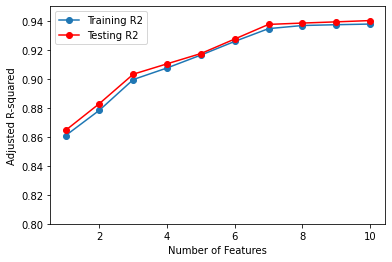

In [6]:
# Plot Adjusted R-squared values for training and testing datasets
predictors = range(1, number_of_features+1)
fig, ax = plt.subplots()
ax.plot(predictors, adjusted_train_R_squared, "o-", label="Training R2")
ax.plot(predictors, adjusted_test_R_squared, "o-", label="Testing R2", color="red")
ax.legend(loc="best")

ax.set_xlabel('Number of Features')
ax.set_ylabel('Adjusted R-squared')
ax.set_ylim([0.80,0.95])

Text(0, 0.5, 'Residuals Sum of Squares')

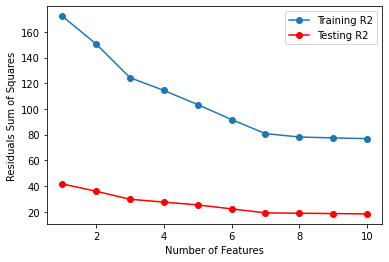

In [7]:
# Print plot for Residuals Sum of Squares
predictors = range(1, number_of_features+1)
fig, ax = plt.subplots()
ax.plot(predictors, training_residuals, "o-", label="Training R2")
ax.plot(predictors, testing_residuals, "o-", label="Testing R2", color="red")
ax.legend(loc="best")

ax.set_xlabel('Number of Features')
ax.set_ylabel('Residuals Sum of Squares')

As we can see, using the best 10 features can only gives us an R<sup>2</sup> score of 0.930. While this could be considered an acceptable accuracy, it could be improved further by using feature interactions.

## Multi-linear Regression with Interactions
### Model Creation

We can multiply all features to obtain the best possible linear model. While this method could achieve an very high Adjusted R<sup>2</sup> score, the number of features and interactions it would have would be of 120 variables. This would be a highly complex and highly inefficient model.

A better solution would be to take the best regression features and use only the interactions between them.

In [8]:
# Create regression model with the interactions of the best 5 features
formula = "Room_Occupancy_Count ~ S1_Light * S2_Light * S7_PIR * S5_CO2_Slope * S3_Temp"
interaction_model = smf.ols(formula=formula, data=X_train).fit()
interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Room_Occupancy_Count   R-squared:                       0.965
Model:                              OLS   Adj. R-squared:                  0.965
Method:                   Least Squares   F-statistic:                     7238.
Date:                  Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                          16:40:22   Log-Likelihood:                 9730.8
No. Observations:                  8103   AIC:                        -1.940e+04
Df Residuals:                      8071   BIC:                        -1.917e+04
Df Model:                            31                                         
Covariance Type:              nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -2.0335      0.094    -21.540      0.000      -2.219      -1.848
S1_Light                                          0.0317      0.003     11.615      0.000       0.026       0.037
S2_Light                                         -0.1725      0.011    -15.941      0.000      -0.194      -0.151
S1_Light:S2_Light                                 0.0010    6.9e-05     14.376      0.000       0.001       0.001
S7_PIR                                           43.7025      1.899     23.014      0.000      39.980      47.425
S1_Light:S7_PIR                                  -0.3968      0.017    -22.854      0.000      -0.431      -0.363
S2_Light:S7_PIR                                   0.0338      0.061      0.557      0.577      -0.085       0.152
S1_Light:S2_Light:S7_PIR                          0.0003      0.000      0.846      0.398      -0.000       0.001
S5_CO2_Slope                                     -0.6812      0.128     -5.312      0.000      -0.933      -0.430
S1_Light:S5_CO2_Slope                            -0.0081      0.004     -2.128      0.033      -0.016      -0.001
S2_Light:S5_CO2_Slope                             0.2049      0.019     10.754      0.000       0.168       0.242
S1_Light:S2_Light:S5_CO2_Slope                   -0.0012      0.000    -10.647      0.000      -0.001      -0.001
S7_PIR:S5_CO2_Slope                             -12.9070      1.204    -10.723      0.000     -15.267     -10.547
S1_Light:S7_PIR:S5_CO2_Slope                      0.1483      0.014     10.922      0.000       0.122       0.175
S2_Light:S7_PIR:S5_CO2_Slope                     -0.1707      0.035     -4.871      0.000      -0.239      -0.102
S1_Light:S2_Light:S7_PIR:S5_CO2_Slope             0.0008      0.000      3.655      0.000       0.000       0.001
S3_Temp                                           0.0823      0.004     21.660      0.000       0.075       0.090
S1_Light:S3_Temp                                 -0.0009      0.000     -8.501      0.000      -0.001      -0.001
S2_Light:S3_Temp                                  0.0066      0.000     15.315      0.000       0.006       0.007
S1_Light:S2_Light:S3_Temp                     -3.803e-05   2.73e-06    -13.909      0.000   -4.34e-05   -3.27e-05
S7_PIR:S3_Temp                                   -1.6829      0.074    -22.706      0.000      -1.828      -1.538
S1_Light:S7_PIR:S3_Temp                           0.0153      0.001     22.541      0.000       0.014       0.017
S2_Light:S7_PIR:S3_Temp                          -0.0011      0.002     -0.476      0.634      -0.006       0.003
S1_Light:S2_Light:S7_PIR:S3_Temp              -1.358e-05   1.48e-05     -0.915      0.360   -4.27

This has an improvement in accuracy when compared to not using interactions, but has too many features due to interactions. Simplifying the model to only use two-way interactions may provide a more efficient model, at the cost of a small loss in accuraccy.

In [9]:
# Create a new model with only two-way interactions at most

formula =  "Room_Occupancy_Count ~ "
formula += "S1_Light * S2_Light + "
formula += "S1_Light * S7_PIR + "
formula += "S1_Light * S5_CO2_Slope + "
formula += "S1_Light * S3_Temp + "

formula += "S2_Light * S7_PIR + "
formula += "S2_Light * S5_CO2_Slope + "
formula += "S2_Light * S3_Temp + "

formula += "S7_PIR * S5_CO2_Slope + "
formula += "S7_PIR * S3_Temp + "
formula += "S5_CO2_Slope * S3_Temp"

reduced_interaction_model = smf.ols(formula=formula, data=X_train).fit()
reduced_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Room_Occupancy_Count   R-squared:                       0.959
Model:                              OLS   Adj. R-squared:                  0.959
Method:                   Least Squares   F-statistic:                 1.253e+04
Date:                  Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                          16:40:22   Log-Likelihood:                 9033.7
No. Observations:                  8103   AIC:                        -1.804e+04
Df Residuals:                      8087   BIC:                        -1.792e+04
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.4928      0.091    -27.524      0.000      -2.670      -2.315
S1_Light                  0.0268      0.002     10.935      0.000       0.022       0.032
S2_Light                 -0.0189      0.002     -8.982      0.000      -0.023      -0.015
S1_Light:S2_Light      2.483e-05   9.67e-07     25.686      0.000    2.29e-05    2.67e-05
S7_PIR                    4.1351      0.367     11.266      0.000       3.416       4.855
S1_Light:S7_PIR          -0.0070      0.000    -58.196      0.000      -0.007      -0.007
S5_CO2_Slope             -0.4799      0.095     -5.040      0.000      -0.667      -0.293
S1_Light:S5_CO2_Slope    -0.0005   3.18e-05    -14.341      0.000      -0.001      -0.000
S3_Temp                   0.1005      0.004     27.583      0.000       0.093       0.108
S1_Light:S3_Temp         -0.0007   9.65e-05     -7.489      0.000      -0.001      -0.001
S2_Light:S7_PIR           0.0013   6.36e-05     20.303      0.000       0.001       0.001
S2_Light:S5_CO2_Slope  7.794e-05   2.17e-05      3.592      0.000    3.54e-05       0.000
S2_Light:S3_Temp          0.0005   8.12e-05      6.492      0.000       0.000       0.001
S7_PIR:S5_CO2_Slope       0.0052      0.003      1.691      0.091      -0.001       0.011
S7_PIR:S3_Temp           -0.1312      0.014     -9.169      0.000      -0.159      -0.103
S5_CO2_Slope:S3_Temp      0.0207      0.004      5.552      0.000       0.013       0.028
==============================================================================
Omnibus:                     8559.309   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1972690.532
Skew:                           4.845   Prob(JB):                         0.00
Kurtosis:                      78.822   Cond. No.                     4.68e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# Calculate prediction errors for 5-Way Interaction Model
interaction_training_error = X_train["Room_Occupancy_Count"] - interaction_model.predict(X_train)
interaction_testing_errors = X_test["Room_Occupancy_Count"] - interaction_model.predict(X_test)

# Calculate the Residuals Sum of Squares for 5-Way Interaction Model
interaction_training_residuals = sum([j**2 for j in interaction_training_error])
interaction_testing_residuals = sum([j**2 for j in interaction_testing_errors])

# Calculate Test R-Squared for 5-Way Interaction Model
# Training R-squared is given by model and was already stored during model selection
interaction_adjusted_test_R_squared = (1 - (interaction_testing_residuals/TSS) * (N-1)/(N-31))

# Print results for 5-Way Interaction Model
print("5-Way Interaction Model")
print("Training Adjusted R-squared", interaction_model.rsquared_adj)
print("Testing Adjusted R-squared", interaction_adjusted_test_R_squared)
print("Training Residuals Sum of Squares", interaction_training_residuals)
print("Testing Residuals Sum of Squares", interaction_testing_residuals)
print()

# Calculate prediction errors for 2-Way Interaction Model
reduced_interaction_training_error = X_train["Room_Occupancy_Count"] - reduced_interaction_model.predict(X_train)
reduced_interaction_testing_errors = X_test["Room_Occupancy_Count"] - reduced_interaction_model.predict(X_test)

# Calculate the Residuals Sum of Squares for 2-Way Interaction Model
reduced_interaction_training_residuals = sum([j**2 for j in reduced_interaction_training_error])
reduced_interaction_testing_residuals = sum([j**2 for j in reduced_interaction_testing_errors])

# Calculate Test R-Squared for 2-Way Interaction Model
# Training R-squared is given by model and was already stored during model selection
reduced_interaction_adjusted_test_R_squared = (1 - (reduced_interaction_testing_residuals/TSS) * (N-1)/(N-31))

# Print results for 2-Way Interaction Model
print("2-Way Interaction Model")
print("Training Adjusted R-squared", reduced_interaction_model.rsquared_adj)
print("Testing Adjusted R-squared", reduced_interaction_adjusted_test_R_squared)
print("Training Residuals Sum of Squares", reduced_interaction_training_residuals)
print("Testing Residuals Sum of Squares", reduced_interaction_testing_residuals)

5-Way Interaction Model
Training Adjusted R-squared 0.9651458718999634
Testing Adjusted R-squared 0.9658036066828476
Training Residuals Sum of Squares 42.962381373811226
Testing Residuals Sum of Squares 10.337624211959216

2-Way Interaction Model
Training Adjusted R-squared 0.958683767923107
Testing Adjusted R-squared 0.9603820098381816
Training Residuals Sum of Squares 51.028749647372294
Testing Residuals Sum of Squares 11.976581580623877


## Results

Using a Multi-Linear Regression both with and without interactons results in a moslty accurate model that can predict the correct number of people in the room around 95% of the time. This is a good result, but the accuracy may improve if a pure classification method is used to solve this problem